In [1]:
import os
import subprocess

def source_lmod_script(script_path):
    """
    Source an Lmod/module script and import environment variables into Python safely,
    suppressing terminal warnings.
    """
    # Use a non-interactive login shell (bash -l), redirect errors
    command = f'bash -l -c "source {script_path} >/dev/null 2>&1; printenv -0"'
    
    proc = subprocess.Popen(command, stdout=subprocess.PIPE, shell=True)
    out, _ = proc.communicate()
    
    # Parse null-separated environment variables
    for env_var in out.split(b'\0'):
        if env_var:
            key, _, value = env_var.partition(b'=')
            os.environ[key.decode()] = value.decode()

# Example usage
M3_BUILD_DIR = "/home/henryi/scratch/venvs/.venv_sbi/bin/"
TUTORIAL_BUILD_DIR = M3_BUILD_DIR
source_lmod_script(f"{M3_BUILD_DIR}/setup.MaCh3.sh")
source_lmod_script(f"{TUTORIAL_BUILD_DIR}/setup.MaCh3Tutorial.sh")
os.environ["OMP_NUM_THREADS"] = "8"

import logging
import sys

my_stderr = sys.stderr = open('errors.txt', 'w')  # redirect stderr to file
get_ipython().log.handlers[0].stream = my_stderr  # log errors to new stderr
get_ipython().log.setLevel(logging.INFO)  # errors are logged at info level

cat: write error: Broken pipe
cat: write error: Broken pipe


In [2]:
from mach3sbitools.ui.sbi_ui import MaCh3SbiUI
from mach3sbitools.plotting.model_comparison import compare_models
from mach3sbitools.utils.device_handler import TorchDeviceHander

from pathlib import Path
import pickle

from tqdm.auto import tqdm

from matplotlib import pyplot as plt
import uproot as ur



Couldn't find DUNE instance
Found MaCh3 Tutorial instance, using that!
FOUND


In [4]:
input_file = Path("/home/henryi/sft/MaCh3Tutorial/TutorialConfigs/FitterConfig.yaml")
ui = MaCh3SbiUI(str(input_file), 'tutorial')
device_handler = TorchDeviceHander()

Trying to open /home/henryi/sft/MaCh3Tutorial/TutorialConfigs/FitterConfig.yaml with tutorial
Opening files with Tutorial!
[Monitor.cpp][info] ##################################
[Monitor.cpp][info] Welcome to:  
[Monitor.cpp][info]   __  __        _____ _     ____  
[Monitor.cpp][info]  |  \/  |      / ____| |   |___ \ 
[Monitor.cpp][info]  | \  / | __ _| |    | |__   __) |
[Monitor.cpp][info]  | |\/| |/ _` | |    | '_ \ |__ < 
[Monitor.cpp][info]  | |  | | (_| | |____| | | |___) |
[Monitor.cpp][info]  |_|  |_|\__,_|\_____|_| |_|____/ 
[Monitor.cpp][info] Version: 2.3.1
[Monitor.cpp][info] ##################################
[Monitor.cpp][info] Using following CPU:
[Monitor.cpp][info] model name	: AMD EPYC 9454 48-Core Processor
[Monitor.cpp][info] cpu MHz		: 3794.013
[Monitor.cpp][info] Architecture:                         x86_64
[Monitor.cpp][info] L1d cache:                            1.5 MiB (48 instances)
[Monitor.cpp][info] L1i cache:                            1.5 MiB (48 instan

In [6]:
input_tree = "/home/henryi/sft/MaCh3Tutorial/Test.root"
input_pkls = {
    "Mechanistic Embedding": "mechanistic_embedding_sbi_fit/mechanistic_embedding_posterior_20M.pkl",
    # "Truncated Proposal": "truncated_proposal_sbi_fit/truncated_proposal_posterior.pkl",
    # "Automatic Transform": "automatic_transform_sbi_fit/automatic_transform_posterior.pkl"
}

pkl_top_level_dir = Path("/home/henryi/sft/TutorialSBI")

In [10]:
samples = {}

for label, file in input_pkls.items():
    with open(pkl_top_level_dir/file, 'rb') as f:
        print(f"Opening {file}")
        posterior = pickle.load(f)
        samples[label] = posterior['posterior'].sample((10_000_000,), x=device_handler.to_tensor(ui.mach3.get_data_bins()))


Opening mechanistic_embedding_sbi_fit/mechanistic_embedding_posterior_20M.pkl


  0%|          | 0/10000000 [00:00<?, ?it/s]

In [11]:
mach3_chain = ur.open(f"{input_tree}:posteriors").arrays(library="np")

  0%|          | 0/16 [00:00<?, ?it/s]

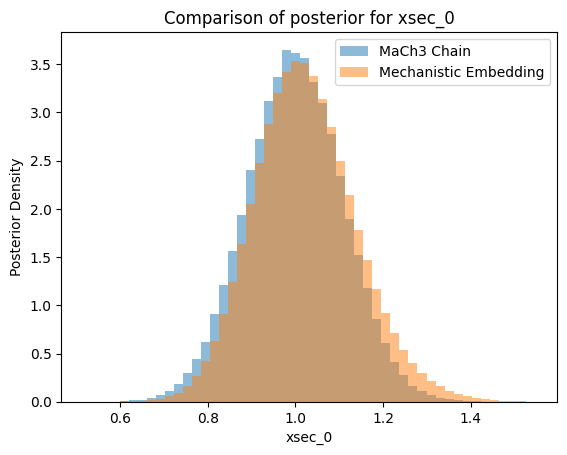

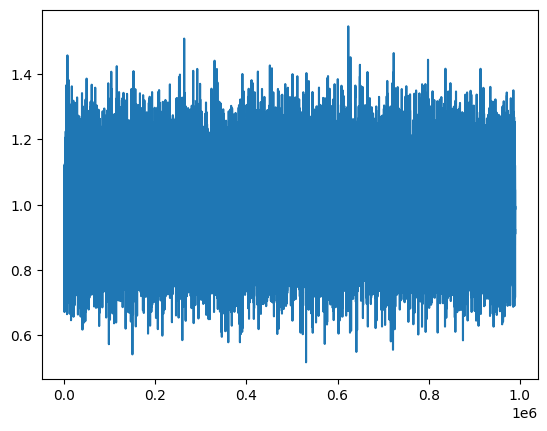

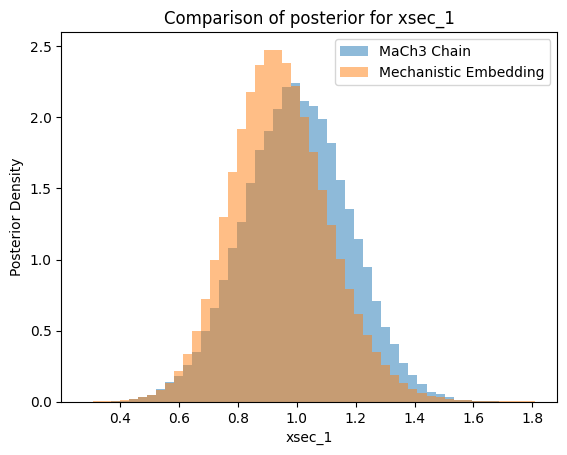

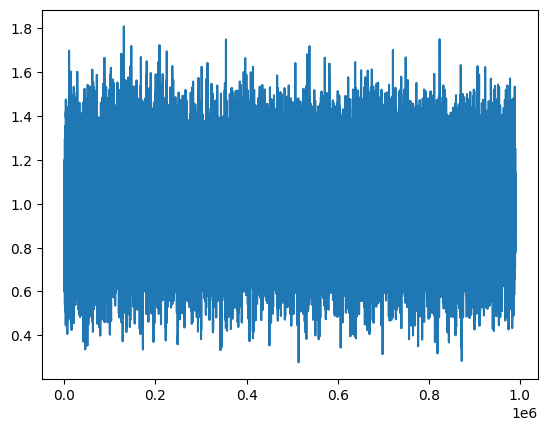

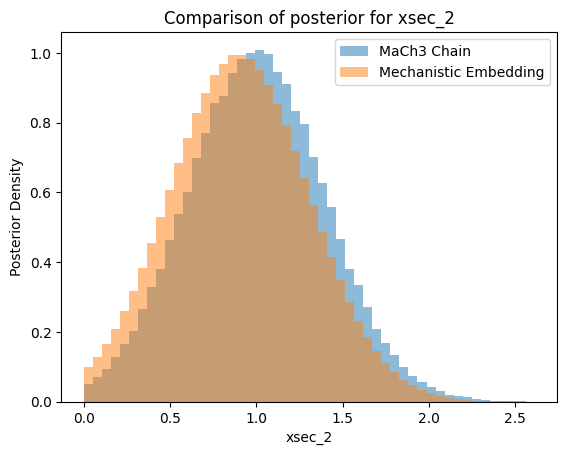

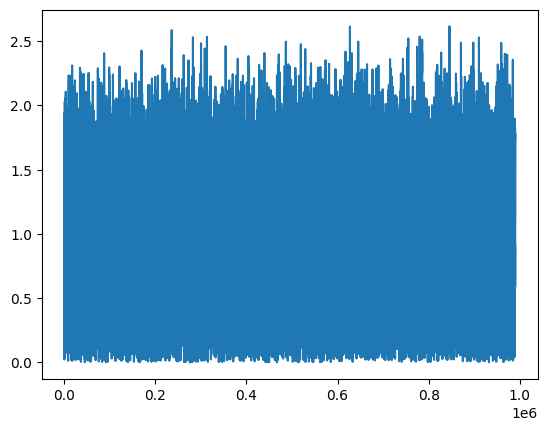

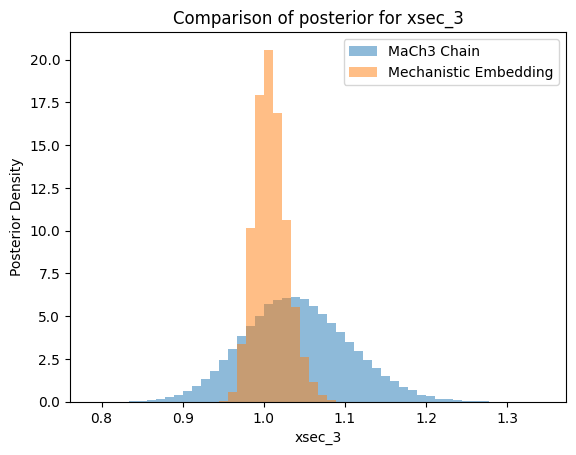

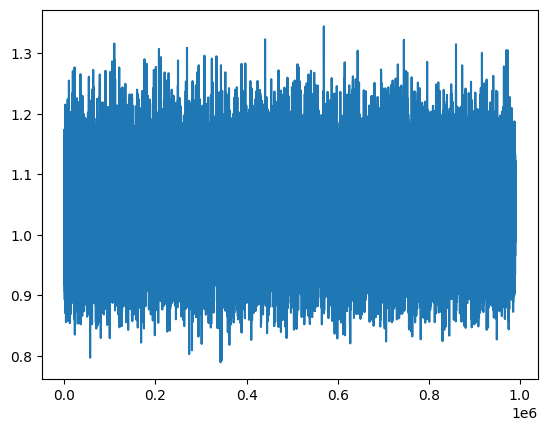

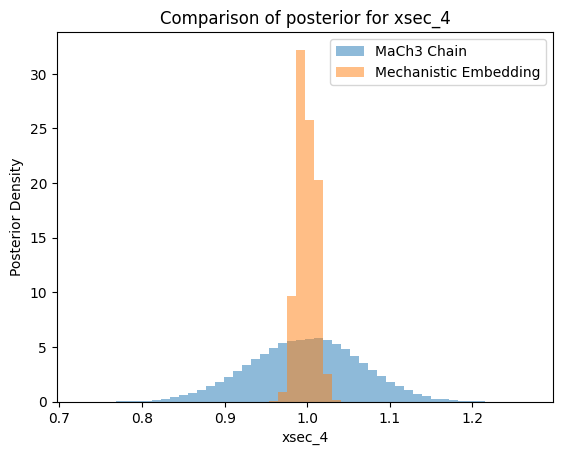

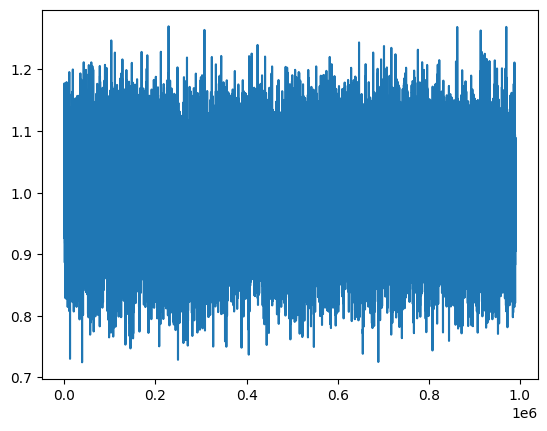

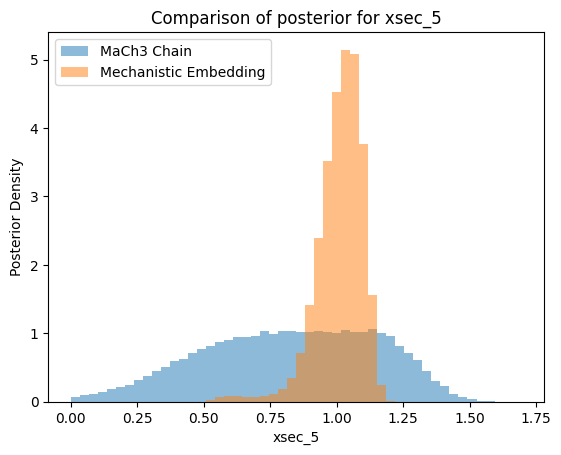

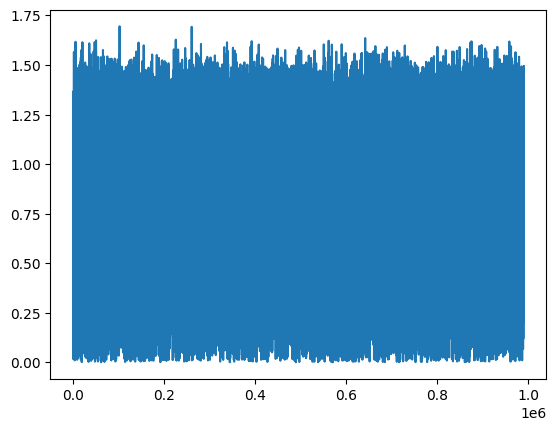

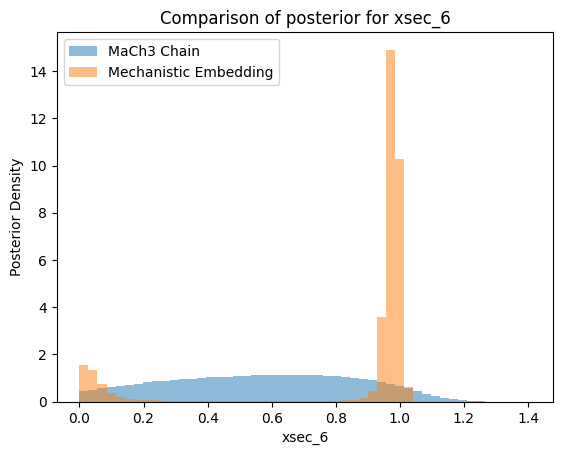

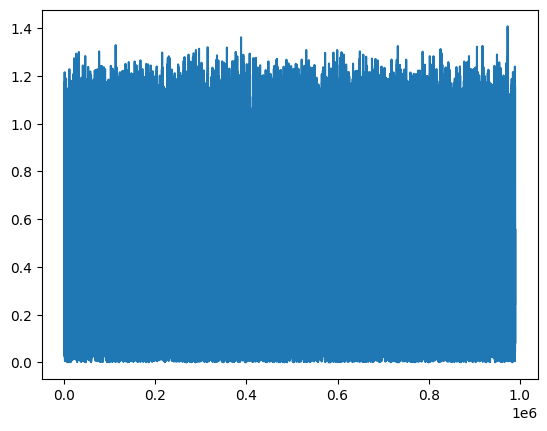

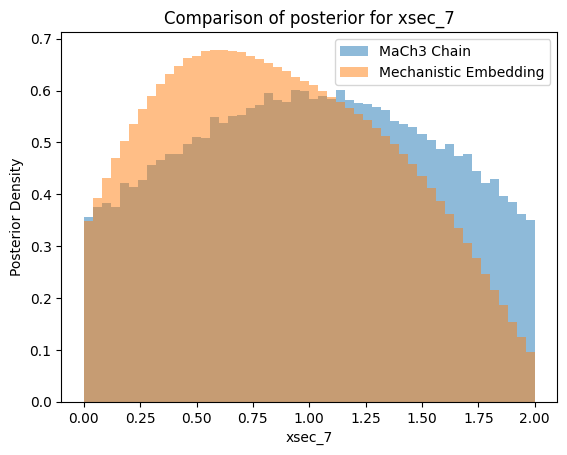

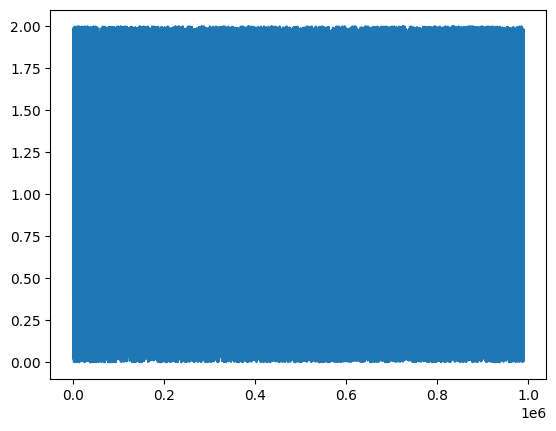

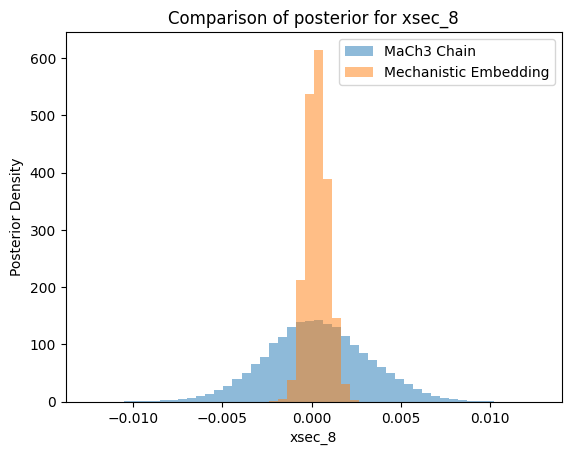

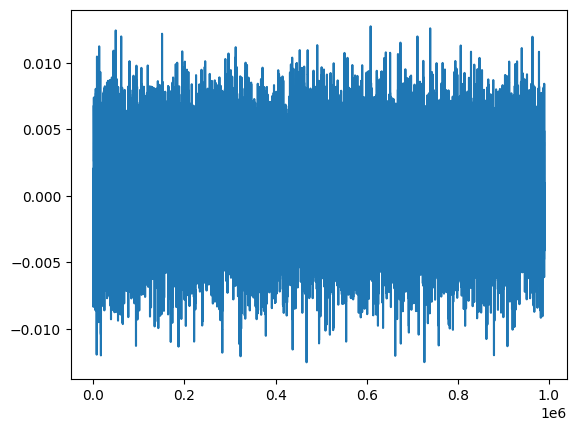

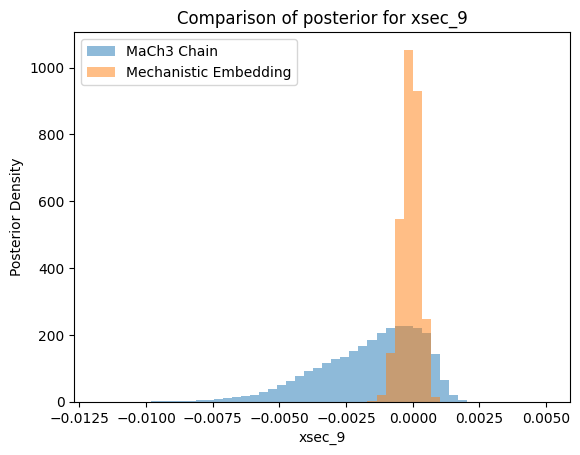

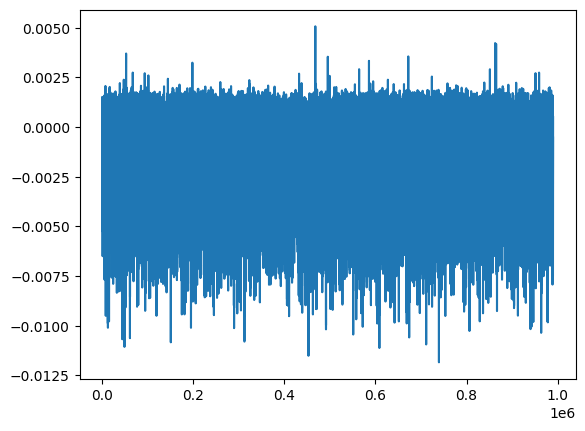

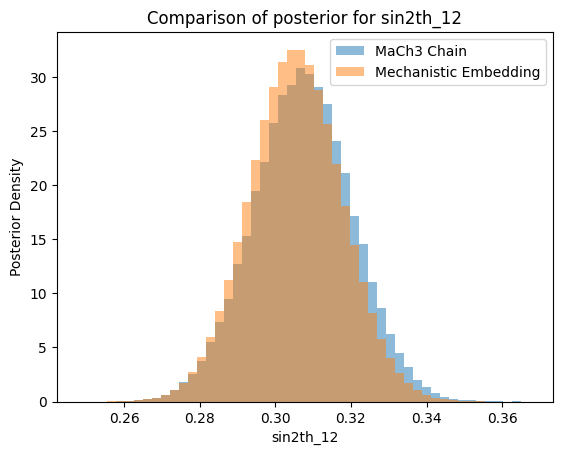

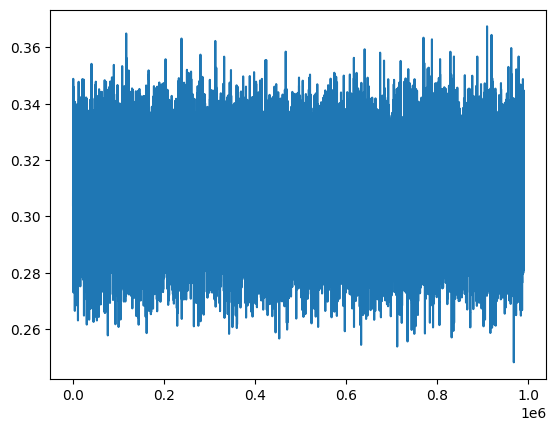

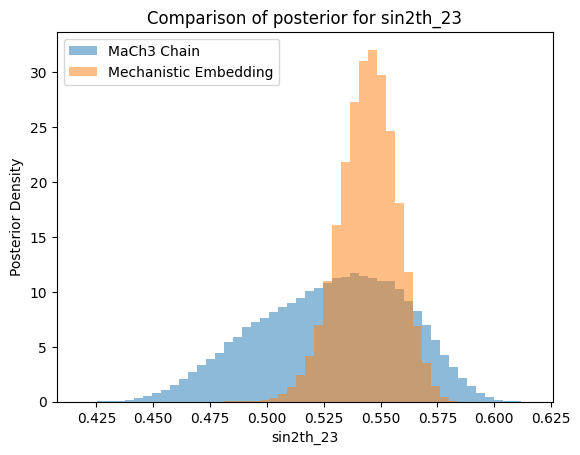

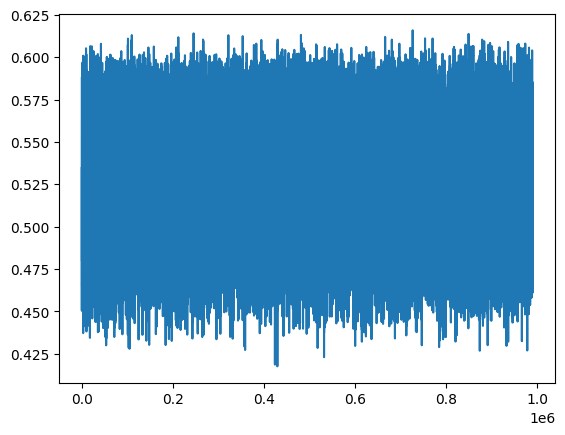

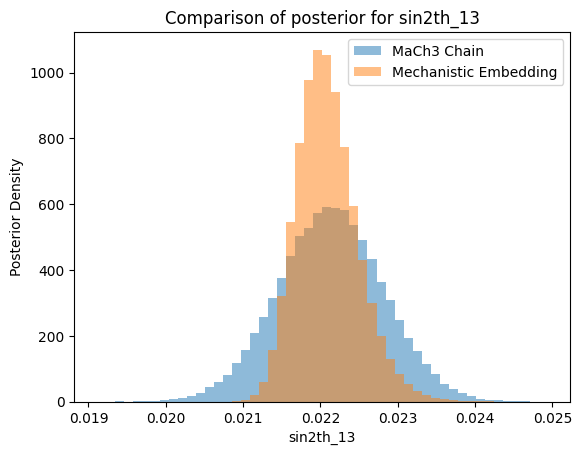

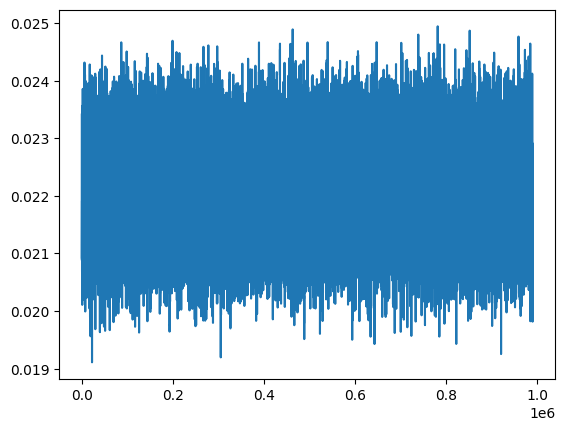

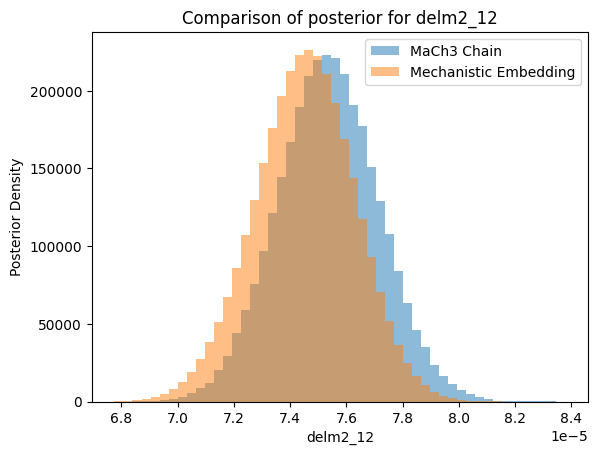

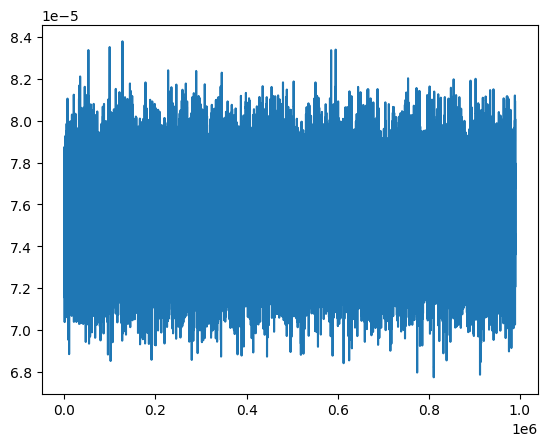

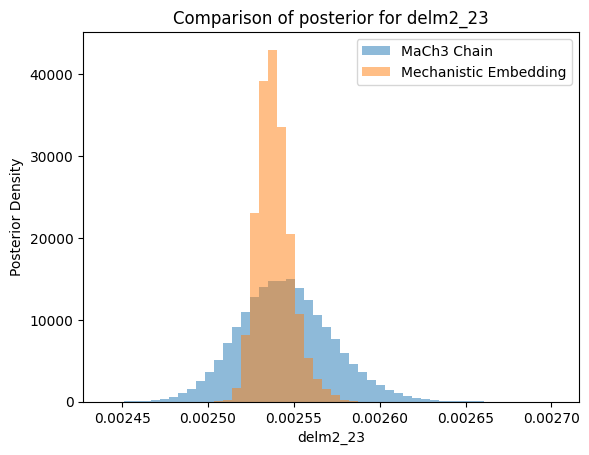

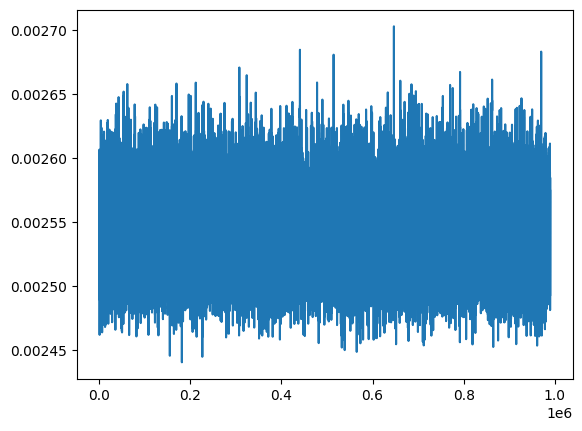

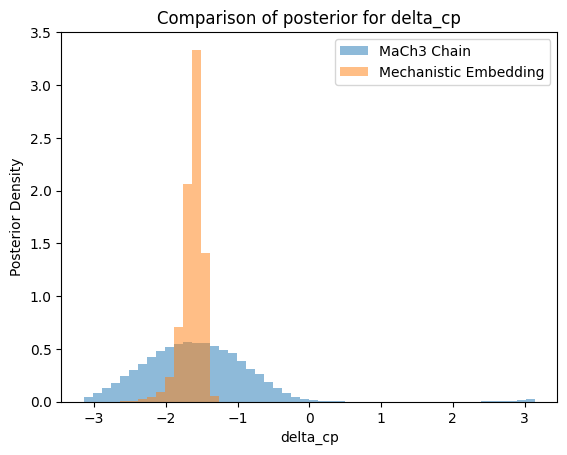

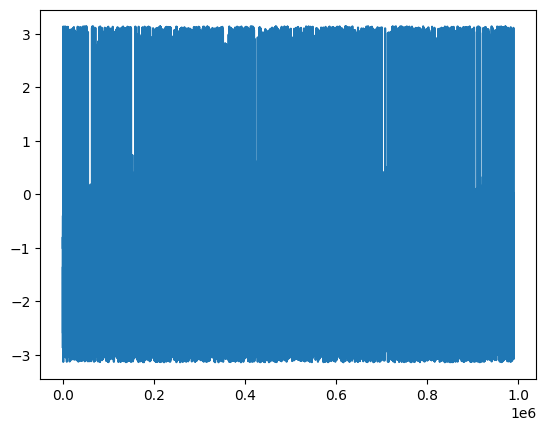

In [14]:
for i, name in tqdm(enumerate(ui.mach3.get_parameter_names()), total=len(ui.mach3.get_parameter_names())):
    _, bins, _ = plt.hist(mach3_chain[name][10000:], bins=50, density=True, alpha=0.5, label="MaCh3 Chain")

    for label, sample in samples.items():
        plt.hist(sample[:, i].cpu().numpy(), bins=bins, density=True, alpha=0.5, label=label)

    plt.legend()
    plt.xlabel(name)
    plt.ylabel("Posterior Density")
    plt.title(f"Comparison of posterior for {name}")
    plt.show()
    plt.close()

    plt.plot(mach3_chain[name][10000:])
    plt.show()

    